In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

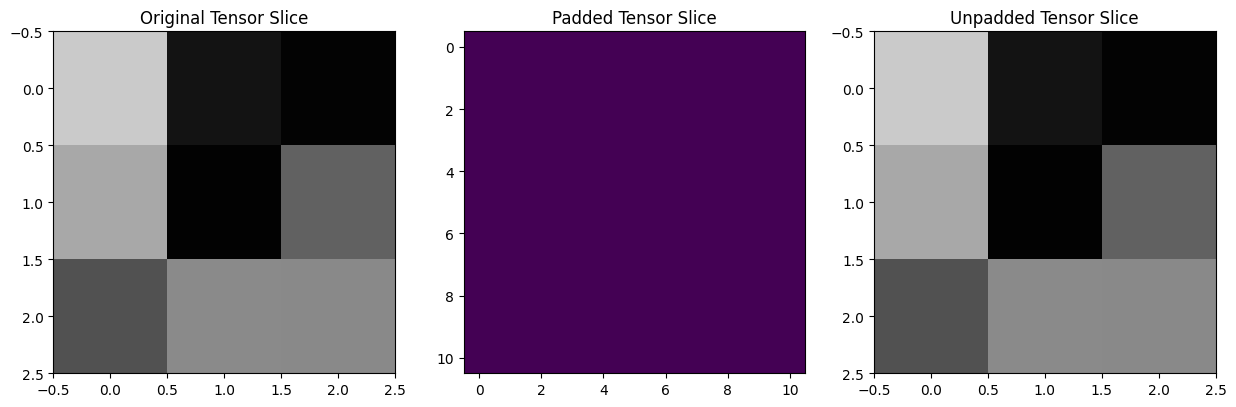

In [13]:
# Initialize x
x = torch.rand(1, 1, 3, 3, 3)

# Initialize the padding
padding = 4
p3d = (padding, padding, padding, padding, padding, padding)

# Pad the tensor
x_padded = F.pad(x, p3d)

# Now let's remove the padding
x_unpadded = x_padded[..., padding:-padding, padding:-padding, padding:-padding]

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# Original tensor
axs[0].imshow(x[0, 0, :, :, 0], cmap='gray', vmin=0, vmax=1)
axs[0].set_title('Original Tensor Slice')

# Padded tensor
axs[1].imshow(x_padded[0, 0, :, :, 0], cmap='gray')
axs[1].set_title('Padded Tensor Slice')

# Unpadded tensor
axs[2].imshow(x_unpadded[0, 0, :, :, 0], cmap='gray', vmin=0, vmax=1)
axs[2].set_title('Unpadded Tensor Slice')

plt.show()
#




        



###DEBUG NORMALIZATION

In [2]:
import torch.nn.functional as F
from utilities import *
from timeit import default_timer
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

/home/smrserraoseabr/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset

class PointGaussianNormalizer(object):
    def __init__(self, dataloader, is_label=False, eps=0.00001):
        super(PointGaussianNormalizer, self).__init__()
        self.eps = eps
        self.mean, self.std = self.batch_mean_and_sd(dataloader, is_label)

    def batch_mean_and_sd(self, loader, is_label):
        cnt = 0
        fst_moment = None
        snd_moment = None

        for data, labels in loader:
            data = labels if is_label else data  # if this is label normalizer, normalize labels
            data_shape = data.shape[-1]
            if fst_moment is None:
                fst_moment = torch.zeros(data_shape)
                snd_moment = torch.zeros(data_shape)

            b, t, h, w, c = data.shape
            nb_pixels = b * t * h * w
            sum_ = torch.sum(data, dim=[0, 1, 2, 3])
            sum_of_square = torch.sum(data ** 2, dim=[0, 1, 2, 3])
            fst_moment += sum_
            snd_moment += sum_of_square
            cnt += nb_pixels

        fst_moment /= cnt
        snd_moment /= cnt

        return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return x * (self.std + self.eps) + self.mean

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [4]:
# Generate some sample data
data = torch.randn(100, 61, 32, 32, 6)*2000
labels = torch.randn(100, 61, 32, 32, 1)*3000

# Create dataloader

dataset = TensorDataset(data, labels)
subset = torch.utils.data.Subset(dataset, range(0, 100))
dataloader = DataLoader(dataset, batch_size=10)

# Create normalizers
input_normalizer = PointGaussianNormalizer(dataloader, is_label=False)
label_normalizer = PointGaussianNormalizer(dataloader, is_label=True)

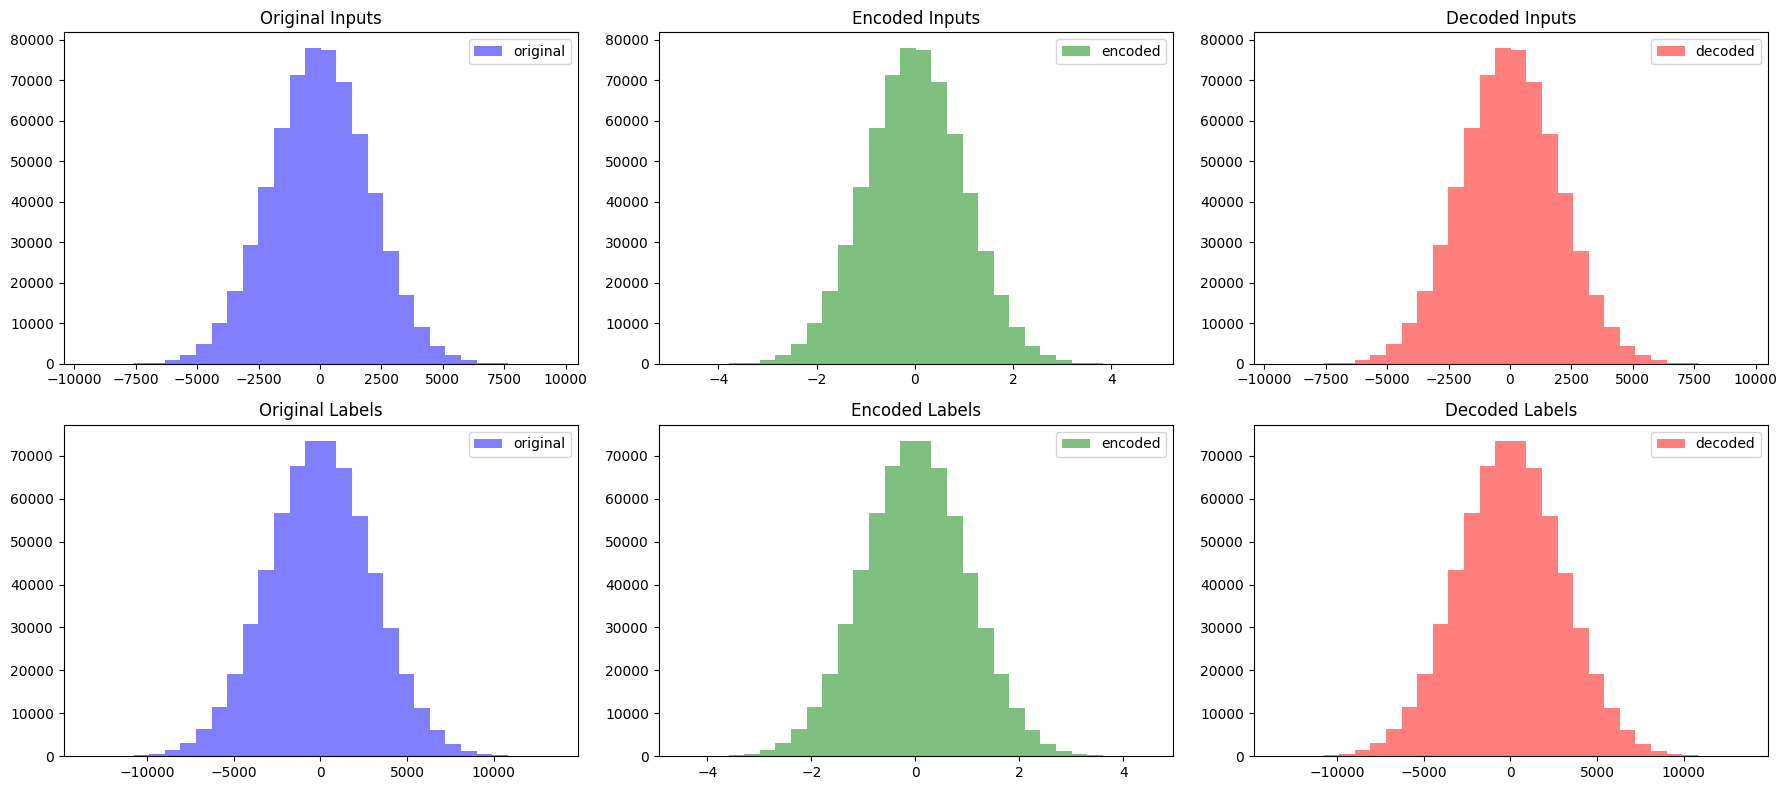

In [5]:
import matplotlib.pyplot as plt

# Pick the first batch of data
inputs, labels = next(iter(dataloader))

# Normalize inputs and labels
normalized_inputs = input_normalizer.encode(inputs)
normalized_labels = label_normalizer.encode(labels)

# Decode the normalized inputs and labels
decoded_inputs = input_normalizer.decode(normalized_inputs)
decoded_labels = label_normalizer.decode(normalized_labels)

# Pick a feature index to plot (any integer from 0 to 5 for your case)
feature_idx = 0

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))

# Plot original inputs
axes[0, 0].hist(inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='b', label='original')
axes[0, 0].set_title('Original Inputs')

# Plot encoded inputs
axes[0, 1].hist(normalized_inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='g', label='encoded')
axes[0, 1].set_title('Encoded Inputs')

# Plot decoded inputs
axes[0, 2].hist(decoded_inputs[..., feature_idx].flatten().cpu().numpy(), bins=30, alpha=0.5, color='r', label='decoded')
axes[0, 2].set_title('Decoded Inputs')

# Plot original labels
axes[1, 0].hist(labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='b', label='original')
axes[1, 0].set_title('Original Labels')

# Plot encoded labels
axes[1, 1].hist(normalized_labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='g', label='encoded')
axes[1, 1].set_title('Encoded Labels')

# Plot decoded labels
axes[1, 2].hist(decoded_labels.flatten().cpu().numpy(), bins=30, alpha=0.5, color='r', label='decoded')
axes[1, 2].set_title('Decoded Labels')

for ax_row in axes:
    for ax in ax_row:
        ax.legend()

plt.tight_layout()
plt.show()


In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset
import os
import xarray as xr

import scipy.io
import h5py


import operator
from functools import reduce
from functools import partial



/home/smrserraoseabr/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# normalization, pointwise gaussian
class PointGaussianNormalizer(object):
    def __init__(self, dataloader, is_label=False, eps=0.00001):
        super(PointGaussianNormalizer, self).__init__()
        self.eps = eps
        self.mean, self.std = self.batch_mean_and_sd(dataloader, is_label)

    def batch_mean_and_sd(self, loader, is_label):
        cnt = 0
        fst_moment = None
        snd_moment = None

        for data, labels in loader:
            data = labels if is_label else data  # if this is label normalizer, normalize labels
            data_shape = data.shape[-1]
            if fst_moment is None:
                fst_moment = torch.zeros(data_shape)
                snd_moment = torch.zeros(data_shape)

            b, t, h, w, c = data.shape
            nb_pixels = b * t * h * w
            sum_ = torch.sum(data, dim=[0, 1, 2, 3])
            sum_of_square = torch.sum(data ** 2, dim=[0, 1, 2, 3])
            fst_moment += sum_
            snd_moment += sum_of_square
            cnt += nb_pixels

        fst_moment /= cnt
        snd_moment /= cnt

        return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

    def encode(self, x):
        return (x - self.mean) / (self.std + self.eps)

    def decode(self, x):
        return x * (self.std + self.eps) + self.mean

    def cuda(self, device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self 


In [7]:
class ReadXarrayDataset(Dataset):
    def __init__(self, folder, input_vars, output_vars, num_files=None):
        self.folder = folder        
        self.file_list = os.listdir(folder)[:num_files] if num_files else os.listdir(folder)            
        self.input_vars = input_vars.copy()
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars.copy()

        # self.input_normalizers = []
        # self.output_normalizers = []
        # self.file_stats = {}



    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder, self.file_list[idx])
        data = xr.open_dataset(file_path)

        X = data['X'].values
        Y = data['Y'].values
        TIME = data['time'].values

        x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
        TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
        data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))
        
        input_data = []
        for var in self.input_vars:
            if 'time' in data[var].dims and 'X' in data[var].dims and 'Y' in data[var].dims:
                input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
            elif 'X' in data[var].dims and 'Y' in data[var].dims:
                scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(0).expand(data.time.size, -1, -1)
                input_data.append(scalar_matrix)
            elif 'time' in data[var].dims:
                scalar_matrix = torch.tensor(data[var][0].values, dtype=torch.float32) 
                scalar_matrix = scalar_matrix.unsqueeze(-1).unsqueeze(-1).expand(-1, data.X.size, data.Y.size)
                input_data.append(scalar_matrix)
                
        #print(len(input_data))

        output_data = []
        for var in self.output_vars:
           output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

        #print(output_data)


        input_data = torch.stack(input_data, dim=-1)
        output_data = torch.stack(output_data, dim=-1)
    
        return input_data, output_data  


In [12]:
#create a variable called resolution 
resolution = 32
folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results" + str(resolution) + "/"
input_vars = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
output_vars = ['CO_2'] 



num_files= 1000
traintest_split = 0.8

batch_size = 61

ntrain = num_files*traintest_split
ntest = num_files - ntrain

learning_rate = 0.001
epochs = 500 


iterations = epochs*(ntrain//batch_size)
modes = 12
width = 128 

# Prepare the path
path = 'ns_fourier_3d_N{}_ep{}_m{}_w{}'.format(ntrain, epochs, modes, width)

# Include in the path the input and output variables
path += '_INPUT_' + '_'.join(input_vars) + '_OUTPUT_' + '_'.join(output_vars)

# Create paths for log, model, and images
path_log = os.path.join('runs', path, 'log')
# Modify here: 'model.pt' will be the filename, not a subdirectory
path_model = os.path.join('runs', path, 'model.pt') 
path_image = os.path.join('runs', path, 'images')

# Create directories
os.makedirs(path_log, exist_ok=True)
os.makedirs(os.path.dirname(path_model), exist_ok=True)  # Get the directory of the path_model
os.makedirs(path_image, exist_ok=True)

# Create paths for train error and test error files
path_train_err = os.path.join(path_log, 'train.txt')
path_test_err = os.path.join(path_log, 'test.txt')



S = 32
#T_in = 61
T = 61

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#device = 'cpu'
print('Using ' + device + ' for training')

################################################################
# load data
################################################################



# Create instance of ReadXarrayDatasetNorm class for training data
dataset = ReadXarrayDataset(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files = num_files)

train_size = int(traintest_split * len(dataset))
test_size = len(dataset) - train_size

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + test_size))


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# We no longer have the entire dataset loaded into memory. The normalization is handled by the Dataset class.
# We also can't directly print the shape of the data because it's not all loaded into memory.



# Normalize input_data and output_data
# Create normalizers for training data
train_input_normalizer = PointGaussianNormalizer(train_loader, is_label=False)
train_output_normalizer = PointGaussianNormalizer(train_loader, is_label=True)

# Create normalizers for test data
test_input_normalizer = PointGaussianNormalizer(test_loader, is_label=False)
test_output_normalizer = PointGaussianNormalizer(test_loader, is_label=True)

train_input_normalizer = train_input_normalizer.cuda(device)
train_output_normalizer = train_output_normalizer.cuda(device)

test_input_normalizer = test_input_normalizer.cuda(device)
test_output_normalizer = test_output_normalizer.cuda(device)




Using cpu for training


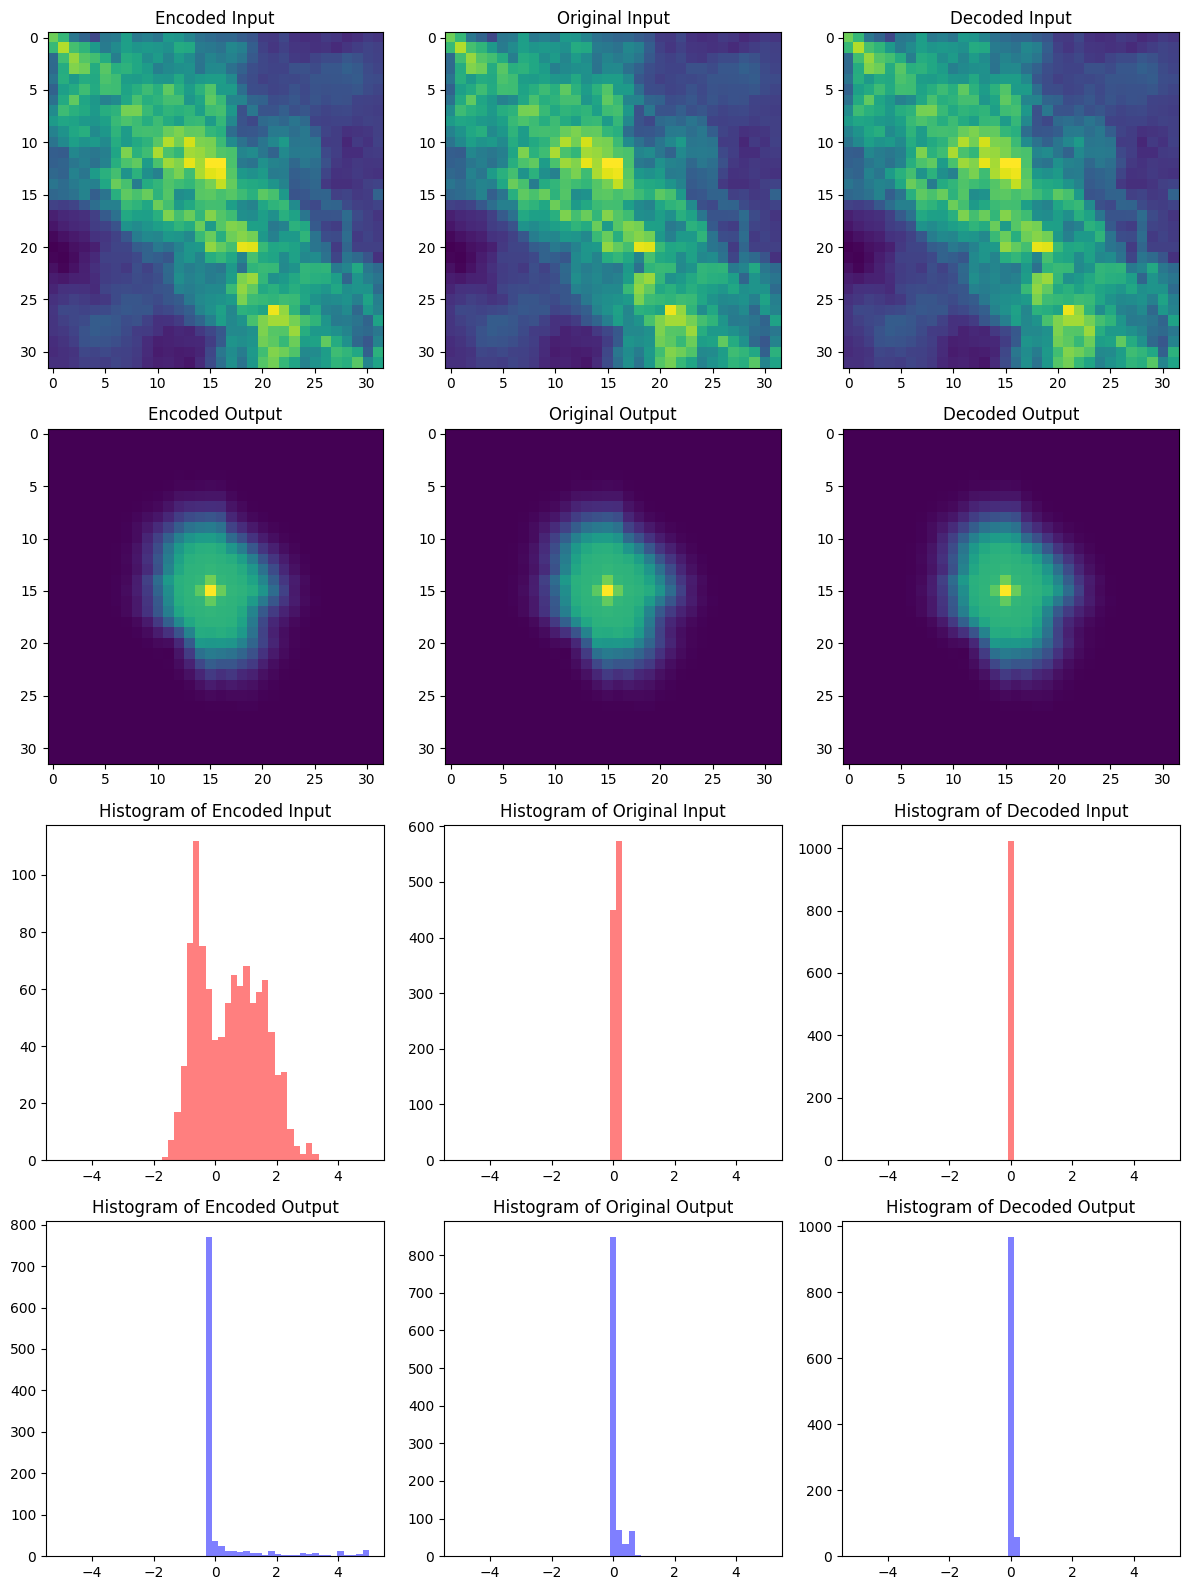

In [30]:
import numpy as np
import matplotlib.pyplot as plt

for index, (x, y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)

    x_encoded = test_input_normalizer.encode(x)
    y_encoded = test_output_normalizer.encode(y)
    y_decoded = test_output_normalizer.decode(y)
    x_decoded = test_input_normalizer.decode(x)

    if index == 0:
        fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 16)) # Adjusted the number of rows

        # Plot images
        ax[0, 0].imshow(x_encoded[0, -1, :, :, 0].T)
        ax[0, 0].set_title('Encoded Input')

        ax[0, 1].imshow(x[0, -1, :, :, 0].T)
        ax[0, 1].set_title('Original Input')

        ax[0, 2].imshow(x_decoded[0, -1, :, :, 0].T)
        ax[0, 2].set_title('Decoded Input')

        ax[1, 0].imshow(y_encoded[0, -1, :, :, 0].T)
        ax[1, 0].set_title('Encoded Output')

        ax[1, 1].imshow(y[0, -1, :, :, 0].T)
        ax[1, 1].set_title('Original Output')

        ax[1, 2].imshow(y_decoded[0, -1, :, :, 0].T)
        ax[1, 2].set_title('Decoded Output')


        bins = np.linspace(-5, 5, 50)

        # Plot histograms
        ax[2, 0].hist(x_encoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 0].set_title('Histogram of Encoded Input')

        ax[2, 1].hist(x[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 1].set_title('Histogram of Original Input')

        ax[2, 2].hist(x_decoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='red')
        ax[2, 2].set_title('Histogram of Decoded Input')

        ax[3, 0].hist(y_encoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 0].set_title('Histogram of Encoded Output')

        ax[3, 1].hist(y[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 1].set_title('Histogram of Original Output')

        ax[3, 2].hist(y_decoded[0, -1, :, :, 0].flatten(), bins=bins, alpha=0.5, color='blue')
        ax[3, 2].set_title('Histogram of Decoded Output')

        plt.tight_layout()
        plt.show()

        break


In [31]:
for index, (x, y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)

    # Assuming you have test_input_normalizer and test_output_normalizer objects

    # Encode the input and output data
    x_encoded = test_input_normalizer.encode(x)
    y_encoded = test_output_normalizer.encode(y)

    # Decode the input and output data
    y_decoded = test_output_normalizer.decode(y_encoded)
    x_decoded = test_input_normalizer.decode(x_encoded)

    # Compare the original and decoded data
    x_diff = torch.abs(x - x_decoded)
    y_diff = torch.abs(y - y_decoded)


    x_mae = torch.mean(x_diff)
    y_mae = torch.mean(y_diff)

    # Print the MAE values
    print("Input MAE:", x_mae.item())
    print("Output MAE:", y_mae.item())

    x_mse = torch.mean(x_diff**2)
    y_mse = torch.mean(y_diff**2)
    x_psnr = 10 * torch.log10(1.0 / x_mse)
    y_psnr = 10 * torch.log10(1.0 / y_mse)

    # Print the PSNR values - PSNR is the peak signal-to-noise ratio which is a measure of the quality of reconstruction
    print("Input PSNR:", x_psnr.item())
    print("Output PSNR:", y_psnr.item())


    # Define tolerance values
    x_tol = 1e-5  # Adjust the tolerance value as needed
    y_tol = 1e-5  # Adjust the tolerance value as needed

    # Check if the decoding is accurate
    if torch.allclose(x, x_decoded, atol=x_tol, rtol=0):
        print("Input decoding is accurate!")
    else:
        print("Input decoding is not accurate.")

    if torch.allclose(y, y_decoded, atol=y_tol, rtol=0):
        print("Output decoding is accurate!")
    else:
        print("Output decoding is not accurate.")
